<a href="https://colab.research.google.com/github/supertramp2/Colab/blob/main/SiameseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import optimizers

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
import json
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
selected_image_size = 125
resize = True
total_sample_size = 10000 # 5k-50k

channel = 1
size = 2

folder_count = 38
image_count = 20 #0-50

if resize == True:
    batch_size=256
else:
    batch_size=64

path =  os.path.join('../input/cell-images-for-detecting-malaria/cell_images/')
print(path)

../input/cell-images-for-detecting-malaria/cell_images/


Now, we define a function for reading our input image. The function read_image takes input as an image and returns the numpy array.
These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function. Next, we define our loss function as contrastive_loss function and compile the model.

In [ ]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
image = mpimg.imread(path+'Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
dim1 = image.shape[0]
print('dim1',dim1)
dim2 = image.shape[1]
print('dim2',dim2)

dim1 148
dim2 142


In [ ]:
image.shape

(148, 142, 3)

In [ ]:
image = mpimg.imread(path+'Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
image.shape

(148, 142, 3)

In [ ]:
def get_data():

    count = 0

    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    
    x_geuine_pair = np.zeros([13780, 2, 3, 64, 64])
    y_genuine = np.zeros([13780,1])
    l = ['../input/cell-images-for-detecting-malaria/cell_images/Parasitized/', '../input/cell-images-for-detecting-malaria/cell_images/Uninfected/']
    
    for i in range(2):
        p = os.listdir(l[i])
        for j in range(0,13779,2):
            if p[j] != 'Thumbs.db'and p[j+1] != 'Thumbs.db':
                img1 = Image.open(l[i] + p[j])
                img1 = img1.resize([64,64])
                img1 = np.array(img1)

                img2 = Image.open(l[i] + p[j+1])
                img2 = img2.resize([64,64])
                img2 = np.array(img2)
                x_geuine_pair[count, 0, :, :, :] = img1.transpose()
                x_geuine_pair[count, 1, :, :, :] = img2.transpose()
                y_genuine[count] = 1
                count += 1
        
    count = 0
    
    x_imposite_pair = np.zeros([13780, 2, 3, 64, 64])
    y_imposite = np.zeros([13780, 1])
    
    p = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/')
    u = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/')

    for j in range(13780):
        if p[j] != 'Thumbs.db' and u[j] != 'Thumbs.db':
            img1 = Image.open(l[0] + p[j])
            img1 = img1.resize([64,64])
            img1 = ImageOps.grayscale(img1)
            img1 = np.array(img1)

            img2 = Image.open(l[1] + u[j])
            img2 = img2.resize([64,64])
            img2 = ImageOps.grayscale(img2)
            img2 = np.array(img2)

            x_imposite_pair[count, 0, :, :, :] = img1.transpose()
            x_imposite_pair[count, 1, :, :, :] = img2.transpose()

            y_imposite[count] = 0
            count += 1
        
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

X, Y = get_data()

In [ ]:
X.shape

(27560, 2, 3, 64, 64)

In [ ]:
Y.shape

(27560, 1)

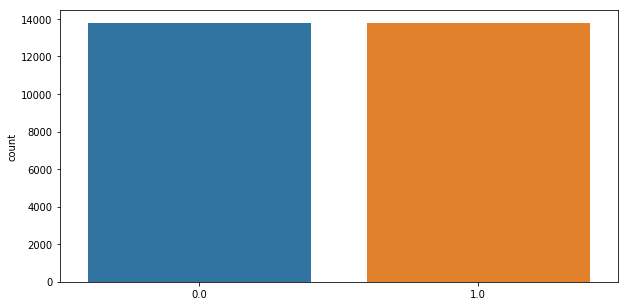

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.countplot(Y[:,0])
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.15)

In [ ]:
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (23426, 2, 3, 64, 64)
x_test (4134, 2, 3, 64, 64)
y_train (23426, 1)
y_test (4134, 1)


In [ ]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [16, 32, 16]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[2], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [ ]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
print('input_dim',input_dim)

input_dim (3, 64, 64)


In [ ]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [ ]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [ ]:
epochs = 20
rms = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#RMSprop()
rms = RMSprop()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [ ]:
model = Model(input=[img_a, img_b], output=distance)
model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 64, 64)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3, 64, 64)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           186018      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

In [ ]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]
img_1.shape
history = model.fit([img_1, img2], y_train, validation_split=.20,
      batch_size= 64, verbose=1, nb_epoch=100,callbacks=callback_early_stop_reduceLROnPlateau)

# Option 1: Save Weights + Architecture
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
print('saved')

Train on 18740 samples, validate on 4686 samples
Epoch 1/100
18740/18740 [==============================] - 8s 418us/step - loss: 0.1543 - accuracy: 0.7753 - val_loss: 0.3151 - val_accuracy: 0.5055
Epoch 2/100
18740/18740 [==============================] - 5s 252us/step - loss: 0.0730 - accuracy: 0.9205 - val_loss: 0.2061 - val_accuracy: 0.6099
Epoch 3/100
18740/18740 [==============================] - 5s 259us/step - loss: 0.0533 - accuracy: 0.9499 - val_loss: 0.1177 - val_accuracy: 0.7945
Epoch 4/100
18740/18740 [==============================] - 5s 246us/step - loss: 0.0416 - accuracy: 0.9607 - val_loss: 0.0913 - val_accuracy: 0.8453
Epoch 5/100
18740/18740 [==============================] - 5s 260us/step - loss: 0.0390 - accuracy: 0.9616 - val_loss: 0.0826 - val_accuracy: 0.8722
Epoch 6/100
18740/18740 [==============================] - 5s 266us/step - loss: 0.0374 - accuracy: 0.9626 - val_loss: 0.0851 - val_accuracy: 0.8796
Epoch 7/100
18740/18740 [==============================] 

Now, we make predictions with test data. Finally, we check our model accuracy.

# Predictions

In [ ]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

print('Accuracy on test set: %0.2f%%' % (100 * compute_accuracy(pred, y_test)))

Accuracy on test set: 99.70%


In [ ]:
pred = model.predict([x_train[:, 0], x_train[:, 1]])

print('* Accuracy on training set: %0.2f%%' % (100  * compute_accuracy(pred, y_train)))

* Accuracy on training set: 99.72%


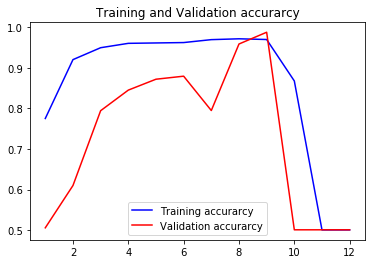

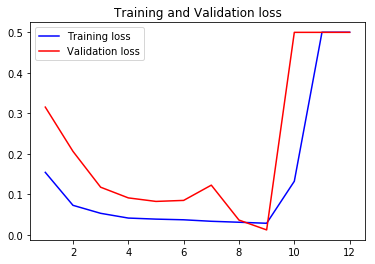

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()